Imports

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Loading and Cleaning Dataset

In [ ]:
df = pd.read_csv('../data/flipkart_product.csv', encoding='latin1')

#Cleaning Review and Summary
df['Review'] = df['Review'].astype(str).str.replace('\n', ' ', regex=False).str.strip()
df['Summary'] = df['Summary'].astype(str).str.replace('\n', ' ', regex=False).str.strip()

df['full_text'] = df['Summary'] + ' ' + df['Review']

def sentiment_label(rate):
    if rate <= 2:
        return 0 #Negative
    elif rate == 3:
        return 1 #Neutral
    else:
        return 2 #Positive
    
df['Rate'] = pd.to_numeric(df['Rate'], errors='coerce')
df['sentiment'] = df['Rate'].apply(sentiment_label)

#Fake review heuristic
df['fake_review'] = ((df['full_text'].str.len() < 30) & (df['Rate'] >= 4)).astype(int)

#Saved cleaned csv file
df.to_csv('../data/cleaned_data.csv', index=False)

print(df.head())


                                         ProductName     Price  Rate  \
0  Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...  ??3,999   5.0   
1  Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...  ??3,999   5.0   
2  Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...  ??3,999   3.0   
3  Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...  ??3,999   1.0   
4  Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...  ??3,999   3.0   

            Review                                            Summary  \
0           Super!  Great cooler.. excellent air flow and for this...   
1          Awesome             Best budget 2 fit cooler. Nice cooling   
2             Fair  The quality is good but the power of air is de...   
3  Useless product                 Very bad product it's a only a fan   
4             Fair                                      Ok ok product   

                                           full_text  sentiment  fake_review  
0  Great cooler.. excellent air flow and for this

Train Test Split

In [7]:
X = df['full_text'].values
y_sentiment = df['sentiment'].values
y_fake = df['fake_review'].values

X_train, X_test, y_sent_train, y_sent_test, y_fake_train, y_fake_test = train_test_split(
    X, y_sentiment, y_fake, test_size=0.2, random_state=42
)


Tokenization

In [10]:
max_words = 5000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

Sentiment Model

In [11]:
model_sentiment = Sequential([
    Embedding(input_dim=max_words, output_dim=64, input_length=max_len),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

model_sentiment.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history_sent = model_sentiment.fit(
    X_train_pad, y_sent_train, 
    epochs=5,
    batch_size=64,
    validation_data=(X_test_pad, y_sent_test)
)

/home/chwla/Desktop/flipkart_sentiment_analysis/venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-09-22 16:22:34.733545: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/5
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 248s 102ms/step - accuracy: 0.7804 - loss: 0.6809 - val_accuracy: 0.7837 - val_loss: 0.6653
Epoch 2/5
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 244s 103ms/step - accuracy: 0.7808 - loss: 0.6750 - val_accuracy: 0.7839 - val_loss: 0.6649
Epoch 3/5
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 241s 101ms/step - accuracy: 0.8393 - loss: 0.5391 - val_accuracy: 0.8544 - val_loss: 0.4997
Epoch 4/5
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 282s 119ms/step - accuracy: 0.9378 - loss: 0.2120 - val_accuracy: 0.9818 - val_loss: 0.0649
Epoch 5/5
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 284s 119ms/step - accuracy: 0.9812 - loss: 0.0689 - val_accuracy: 0.9836 - val_loss: 0.0574


In [12]:
model_fake = Sequential([
    Embedding(input_dim=max_words, output_dim=64, input_length=max_len),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid') 
])

model_fake.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history_fake = model_fake.fit(
    X_train_pad, y_fake_train,
    epochs=5,
    batch_size=64,
    validation_data=(X_test_pad, y_fake_test)
)

Epoch 1/5
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 304s 125ms/step - accuracy: 0.6412 - loss: 0.6480 - val_accuracy: 0.6704 - val_loss: 0.6296
Epoch 2/5
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 299s 126ms/step - accuracy: 0.7086 - loss: 0.5982 - val_accuracy: 0.7034 - val_loss: 0.5997
Epoch 3/5
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 252s 106ms/step - accuracy: 0.7183 - loss: 0.5710 - val_accuracy: 0.9206 - val_loss: 0.2137
Epoch 4/5
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 264s 111ms/step - accuracy: 0.9409 - loss: 0.1567 - val_accuracy: 0.9682 - val_loss: 0.0928
Epoch 5/5
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 305s 129ms/step - accuracy: 0.9662 - loss: 0.0990 - val_accuracy: 0.9717 - val_loss: 0.0821


In [14]:
model_sentiment.save('../models/sentiment_model.h5')
model_fake.save('../models/fake_model.h5')

Evaluating

In [16]:
def evaluate_model(model, X_test, y_test, task="Task", is_binary=False):
    preds = model.predict(X_test)
    if is_binary:
        pred_classes = (preds > 0.5).astype("int32")
    else:
        pred_classes = np.argmax(preds, axis=1)

    print(f"\n{task} Classification Report:")
    print(classification_report(y_test, pred_classes))

    print(f"{task} Confusion Matrix:")
    print(confusion_matrix(y_test, pred_classes))

# Run evaluations
evaluate_model(model_sentiment, X_test_pad, y_sent_test, task="Sentiment", is_binary=False)
evaluate_model(model_fake, X_test_pad, y_fake_test, task="Fake Review", is_binary=True)

1187/1187 ━━━━━━━━━━━━━━━━━━━━ 24s 20ms/step

Sentiment Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      5133
           1       0.97      0.87      0.92      3081
           2       0.99      1.00      0.99     29761

    accuracy                           0.98     37975
   macro avg       0.98      0.95      0.96     37975
weighted avg       0.98      0.98      0.98     37975

Sentiment Confusion Matrix:
[[ 5023    23    87]
 [  103  2676   302]
 [   48    59 29654]]
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 24s 20ms/step

Fake Review Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98     23356
           1       0.95      0.97      0.96     14619

    accuracy                           0.97     37975
   macro avg       0.97      0.97      0.97     37975
weighted avg       0.97      0.97      0.97     37975

Fake Review Confusion Matrix:
[[22654   

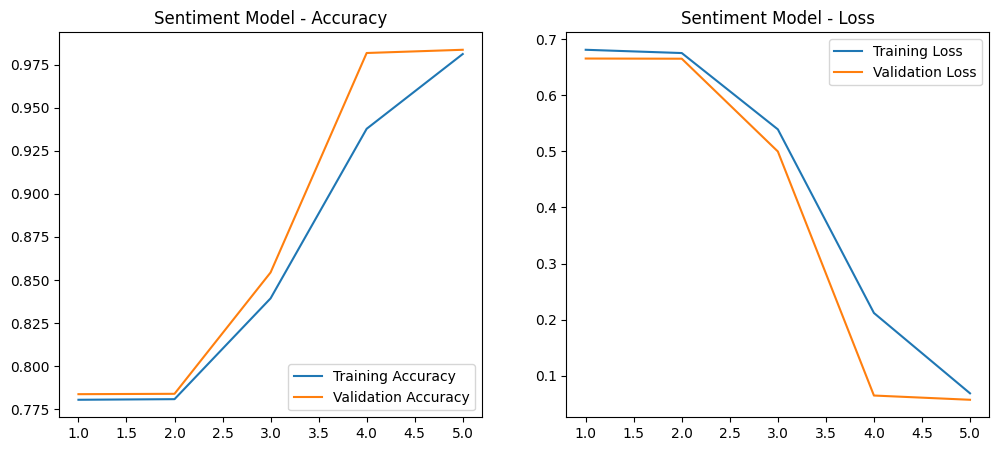

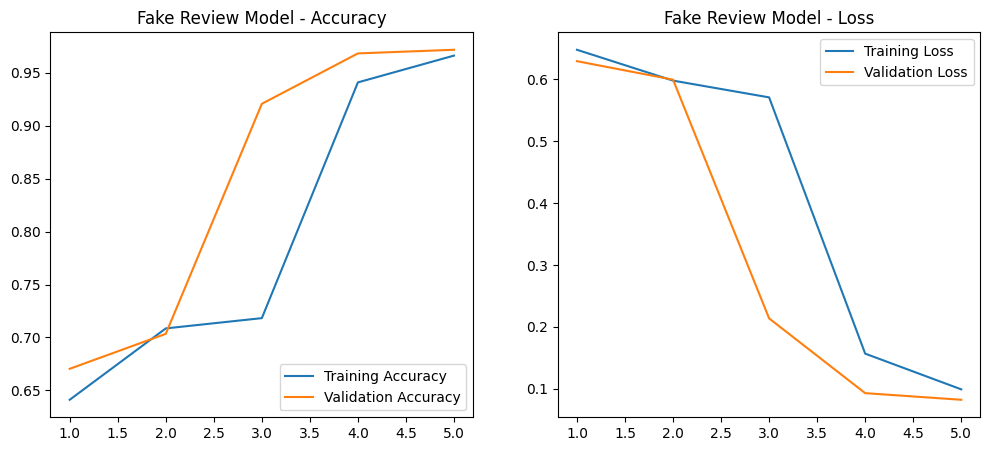

In [19]:
def plot_history(history, title="Model Training"):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{title} - Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{title} - Loss')

    plt.show()


# Plot for Sentiment model
plot_history(history_sent, title="Sentiment Model")

# Plot for Fake Review model
plot_history(history_fake, title="Fake Review Model")